In [ ]:
"""
Author: sanskar khandelwal
Team Name: TheLastTransformer
Team Members: 1
Leaderboard Rank: 56
"""

## Project Summary: Soil Image Classification
The goal of this project was to classify soil images into four categories: Alluvial, Black, Clay, and Red. Since the dataset was small and training deep models from scratch gave poor results, I adopted a hybrid deep learning + classical ML approach for better performance and efficiency.

## 1. Imports & Environment Setup

Load all required libraries and set device for computation.

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import joblib

# ⚙️ Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Define Data Paths & Load CSVs

Point to train/test image folders and label files, then read them into pandas.

In [ ]:
# 📂 Data paths
data_root = "/kaggle/input/soil-classification/soil_classification-2025"
train_img_dir = os.path.join(data_root, "train")
test_img_dir = os.path.join(data_root, "test")
train_csv = os.path.join(data_root, "train_labels.csv")
test_csv = os.path.join(data_root, "test_ids.csv")

# 📄 Load data
df_train = pd.read_csv(train_csv)
df_test = pd.read_csv(test_csv)

## 3. Encode String Labels to Integers

Map each soil type string to an integer index for model training.

In [ ]:
label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['soil_type'])
class_names = label_encoder.classes_
num_classes = len(class_names)


In [ ]:

## 4. Image Transformations
#
# 🧪 Transform
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

## 5. Feature Extractor Setup

Load pretrained ResNet-18, drop its classifier head, set to eval mode.

In [ ]:
# 🧠 Feature extractor
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet18.fc = torch.nn.Identity()
resnet18 = resnet18.to(device)
resnet18.eval()

print("🧠 ResNet18 Architecture:\n")
print(resnet18)


## 6. Feature Extraction Function

Iterate over image paths, apply transforms, run through ResNet to get feature vectors.
Build file-path list, extract features for all train images, and collect labels.

In [ ]:
def extract_features(img_paths):
    """
    Given a list of image file paths, returns a NumPy array of shape
    (n_images, feature_dim) containing extracted features.
    """
    feats = []
    for path in tqdm(img_paths, desc="Extracting features"):
        img     = Image.open(path).convert("RGB")
        tensor  = img_transform(img).unsqueeze(0).to(device)  # add batch dim
        with torch.no_grad():
            feat = resnet18(tensor).cpu().numpy().flatten()
        feats.append(feat)
    return np.vstack(feats)

## 7. Prepare Training Data

Build file-path list, extract features for all train images, and collect labels.

In [ ]:
# 📷 Build full train image paths
train_paths = [os.path.join(train_img_dir, fn) for fn in df_train["image_id"]]

# 🔍 Extract features & labels
X = extract_features(train_paths)      # shape (N, D)
y = df_train["label"].values           # integer labels

## 8. 5-Fold Cross-Validation

Train a RandomForest on each fold, record macro-F1 and print detailed reports.

 9. Plot F1 Score per Fold

Visualize per-fold performance to inspect variance.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


🧠 ResNet18 Architecture:

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (re

Extracting features: 100%|██████████| 1222/1222 [00:24<00:00, 50.10it/s]



Fold 1 F1-score: 0.9394
               precision    recall  f1-score   support

Alluvial soil       0.95      0.93      0.94       106
   Black Soil       0.95      0.91      0.93        46
    Clay soil       1.00      0.93      0.96        40
     Red soil       0.87      0.98      0.92        53

     accuracy                           0.94       245
    macro avg       0.94      0.94      0.94       245
 weighted avg       0.94      0.94      0.94       245


Fold 2 F1-score: 0.9394
               precision    recall  f1-score   support

Alluvial soil       0.95      0.94      0.95       106
   Black Soil       0.98      0.94      0.96        47
    Clay soil       0.90      0.90      0.90        40
     Red soil       0.93      0.98      0.95        52

     accuracy                           0.94       245
    macro avg       0.94      0.94      0.94       245
 weighted avg       0.94      0.94      0.94       245


Fold 3 F1-score: 0.9545
               precision    recall  f1-

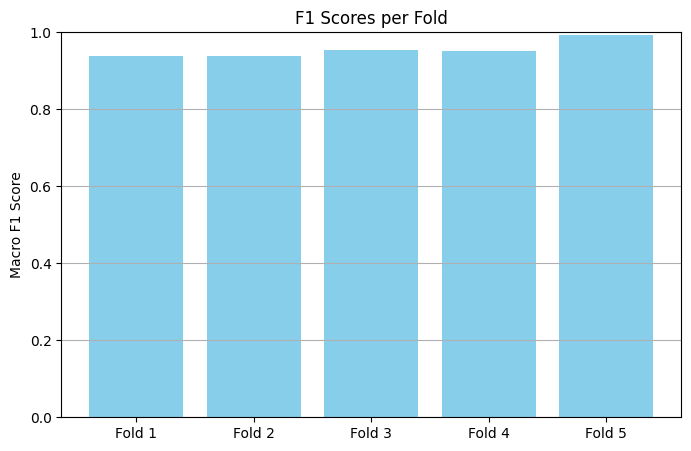


Average CV F1-score: 0.9554
✅ Final model and label encoder saved.


Extracting features: 100%|██████████| 341/341 [00:05<00:00, 64.13it/s]

✅ submission.csv saved!


In [ ]:






# 🔁 5-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = []

for fold, (tr_idx, val_idx) in enumerate(cv.split(X, y)):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X[tr_idx], y[tr_idx])
    preds = clf.predict(X[val_idx])
    f1 = f1_score(y[val_idx], preds, average='macro')
    fold_scores.append(f1)
    print(f"\nFold {fold+1} F1-score: {f1:.4f}")
    print(classification_report(y[val_idx], preds, target_names=class_names))

# 📊 F1 Score Plot
plt.figure(figsize=(8, 5))
plt.bar([f"Fold {i+1}" for i in range(5)], fold_scores, color='skyblue')
plt.ylim(0, 1)
plt.title("F1 Scores per Fold")
plt.ylabel("Macro F1 Score")
plt.grid(True, axis='y')
plt.show()

print(f"\nAverage CV F1-score: {np.mean(fold_scores):.4f}")

# 💾 Train final model on all data
final_clf = RandomForestClassifier(n_estimators=100, random_state=42)
final_clf.fit(X, y)
joblib.dump(final_clf, "final_model.pkl")
np.save("label_encoder_classes.npy", class_names)
print("✅ Final model and label encoder saved.")

# ⏳ Inference
# Reset resnet18 to pretrained + new head (not used since features are used)
# 📷 Test feature extraction setup — same as training
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet18.fc = torch.nn.Identity()
resnet18 = resnet18.to(device)
resnet18.eval()

# Extract test features
test_paths = [os.path.join(test_img_dir, fname) for fname in df_test['image_id']]
X_test = extract_features(test_paths)

# 🔮 Predict using trained RF
test_preds = final_clf.predict(X_test)
predicted_labels = label_encoder.inverse_transform(test_preds)

# 📤 Create submission
df_submission = pd.DataFrame({
    'image_id': df_test['image_id'],
    'soil_type': predicted_labels
})
df_submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved!")



## 12.  Visualize Model Architecture

Install `torchviz` and render the computation graph of ResNet-18.

In [3]:
pip install torchviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

## 13. Plot Predicted Class Distribution

Show how many test images were assigned to each soil type.

In [4]:
# printing model architecture as image 

from torchviz import make_dot

# 🧪 Dummy input for visualization
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# 🔄 Get output to build graph
output = resnet18(dummy_input)

# 🧠 Visualize and save
dot = make_dot(output, params=dict(list(resnet18.named_parameters())))
dot.format = "png"
dot.render("resnet18_graph")

print("🖼️ Model architecture graph saved as resnet18_graph.png")


🖼️ Model architecture graph saved as resnet18_graph.png


## 13. Plot Predicted Class Distribution

Show how many test images were assigned to each soil type.

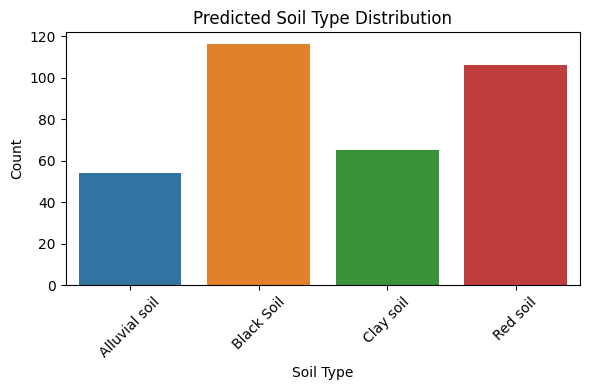

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 🎯 1. Count of predicted classes
plt.figure(figsize=(6,4))
sns.countplot(x='soil_type', data=df_submission, order=label_encoder.classes_)
plt.title("Predicted Soil Type Distribution")
plt.xlabel("Soil Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 14. Display Sample Predictions

Show a grid of test images alongside their predicted labels.

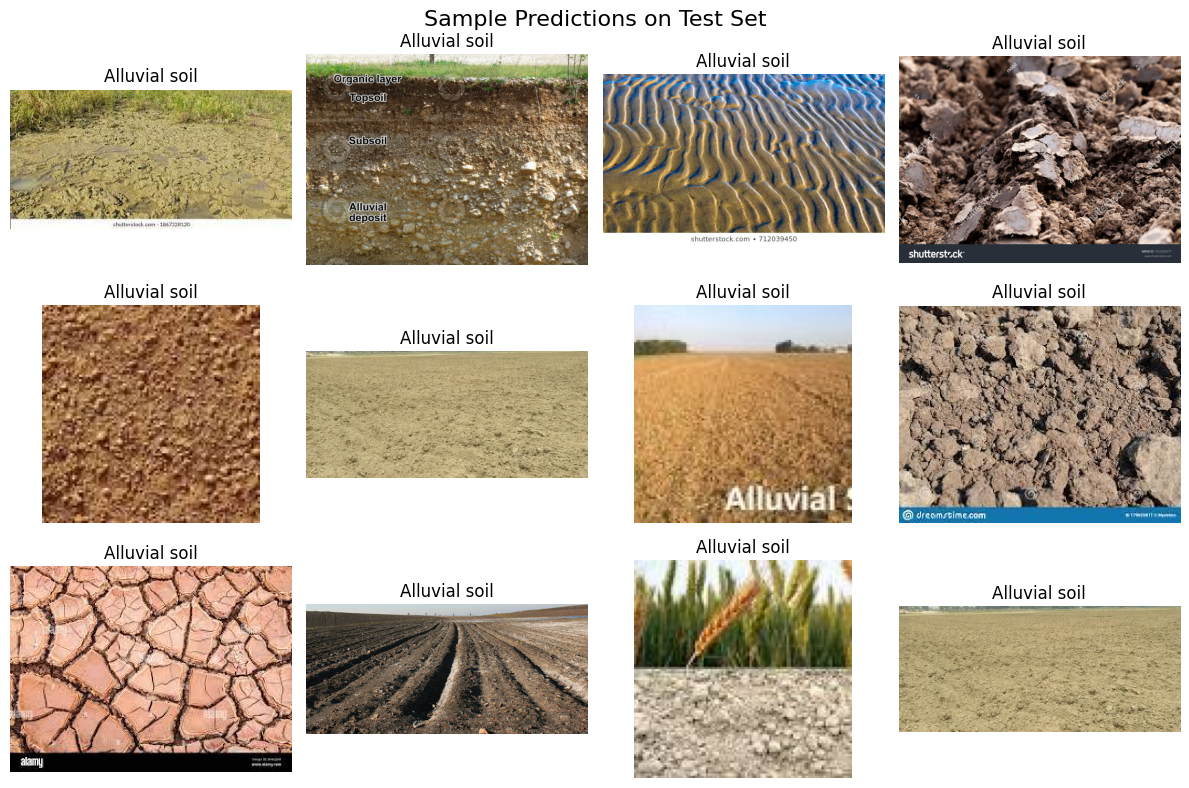

In [5]:
# 🖼️ Visualize some test predictions
num_images = 12
plt.figure(figsize=(12, 8))

for i in range(num_images):
    img_id = df_submission.iloc[i]['image_id']
    pred_label = df_submission.iloc[i]['soil_type']
    img_path = os.path.join(test_img_dir, img_id)
    image = Image.open(img_path).convert('RGB')

    plt.subplot(3, 4, i+1)
    plt.imshow(image)
    plt.title(pred_label)
    plt.axis('off')

plt.suptitle("Sample Predictions on Test Set", fontsize=16)
plt.tight_layout()
plt.show()


## 15. Feature Importance Analysis

Extract and plot the top-20 feature importances from the Random Forest.

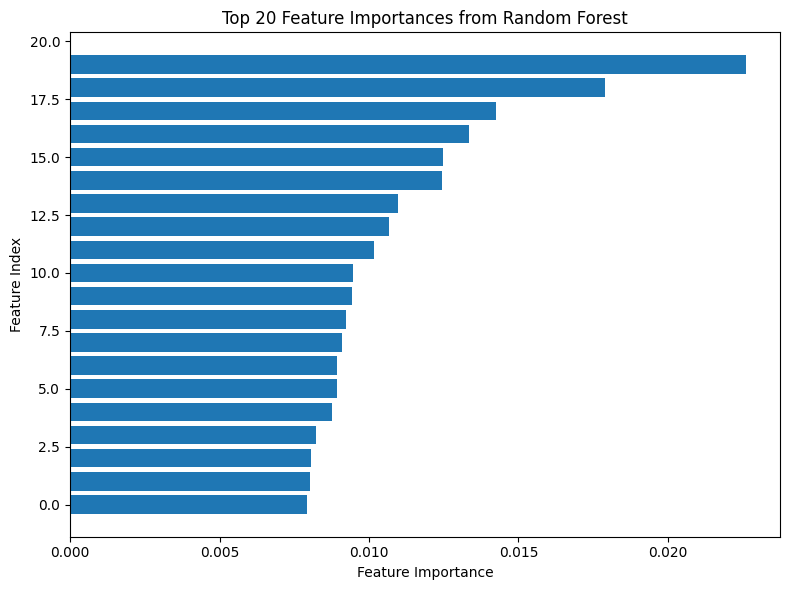

In [6]:
# 📊 Feature importance (top 20)
importances = final_clf.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20 important features

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Index")
plt.title("Top 20 Feature Importances from Random Forest")
plt.tight_layout()
plt.show()
